# OLIST Part 3 : Segmentation refreshment

In [1]:
#dataframe et basic calculation
import pandas as pd
import numpy as np
# plotting
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
    
# File system & regular expression operations
import os
import re
from dateutil.relativedelta import relativedelta
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#preprocessing
from sklearn.preprocessing import StandardScaler
#algorithms
from sklearn.cluster import KMeans
#metrics
from sklearn.metrics.cluster import adjusted_rand_score

## Dataset attributes
The dataset loaded here is one of jointure of customers and orders used in the first notebook. 

In [2]:
#get the output fold path
outputWD = os. getcwd()+"\\output\\"
#import data
customers_orders = pd.read_csv(outputWD +  'customers_orders.csv')
#put purchase time to datetime format
customers_orders['order_purchase_timestamp']=customers_orders['order_purchase_timestamp']\
.apply(pd.to_datetime, errors='coerce')

#visualize the dateframe
print('dataset customers_orders shape:', customers_orders.shape)
customers_orders.head()

dataset customers_orders shape: (101923, 12)


,order_id,customer_id,order_purchase_timestamp,order_approval_hours,order_delivery_days,order_delivery_delay,recency,customer_unique_id,payment_value,purchase_month,first_purchase_month,diff_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,0.178333,6.062650,-7.107488,-380.273438,7c396fd4830fd04220f754e42b4e5bff,18.12,2017-10-01,2017-09-01,1
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,0.178333,6.062650,-7.107488,-380.273438,7c396fd4830fd04220f754e42b4e5bff,2.00,2017-10-01,2017-09-01,1
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,0.178333,6.062650,-7.107488,-380.273438,7c396fd4830fd04220f754e42b4e5bff,18.59,2017-10-01,2017-09-01,1
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,30.713889,12.039410,-5.355729,-84.867141,af07308b275d755c9edb36a90c618231,141.46,2018-07-01,2018-07-01,0
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,0.276111,9.178113,-17.245498,-70.369086,3a653a41f6f9fc3d2a113cf8398680e8,179.12,2018-08-01,2018-08-01,0


In [3]:
#calculate the period
first_day = customers_orders.order_purchase_timestamp.min()
last_day = customers_orders.order_purchase_timestamp.max()
period = round((last_day - first_day) / np.timedelta64(1, 'M'))

print("The dataframe has", period, "months ordre informtions, ", 
      "from", first_day, "to", last_day,".")

The dataframe has 24 months ordre informtions, from 2016-09-04 21:15:19 to 2018-09-03 09:06:57 .


## K means customer segmentation temporal stability plots

**Defining the preprocessing function**

In [4]:
def preprocess(data):
    """Standardize features by removing the mean and scaling to unit variance"""
       
    scaler = StandardScaler()
    data = data.set_index(['customer_unique_id'])
    std = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns)
    
    return std

**Determining the clustering function**

In [5]:
#fit the data
kmeans5 = KMeans(init='k-means++', #et the initial cluster centroids
                algorithm='auto',
                n_clusters=5,
                max_iter=500,
                random_state=1,
                verbose=0)


**Defining the ARI calculating function**

In [6]:
def ari_score(first_day, last_day, duration):
    """
The adjusted Rand index is a symmetric measure, usually used for clustering validation.
It's thus ensured to have a value close to 0.0 for random labeling and 1.0 when the clusterings are identical.
    
This function uses the first period's clustering as reference, and it does the same for customers.
That means the ARI score evalues the clustering changes of the inital customer group.        
    """
    
    #initialization
    ari_score=[]
    customer_nb=[]
    #calculate the period 
    period = round((last_day - first_day) / np.timedelta64(1, 'M'))
    
    for n in range(0,period-duration+1,1):
        #calculate wanted period
        first_month = first_day + relativedelta(months=n)
        last_month = first_month + relativedelta(months=duration)
        #filter orders past in that period
        temp = customers_orders.query\
        ('order_purchase_timestamp>=@first_month and order_purchase_timestamp<=@last_month')
        #calculate rencency days
        temp['recency'] = (temp['order_purchase_timestamp']-last_month)\
        /pd.to_timedelta(1, 'day')
        #calculate frequency and monetary in that period
        temp = temp.groupby('customer_unique_id').agg({'recency':'max',
                                                       'order_id':'count',
                                                       'payment_value':'sum' })
        temp.columns=['recency','frequency','monetary']
        #keep the inital customers    
        if n==0:
            init_customers = temp.index.tolist()

        #normalizate the datafram
        norm = preprocess(temp.reset_index())
        #clustering
        kmeans_f = kmeans5.fit(norm)

        #keep the first labels as reference
        if n==0:
            init_labels = temp.assign(cluster=kmeans_f.labels_)

        #only keep the inital customers score
        mask = temp.index.isin(init_customers)
        customers_list = temp.index[mask].tolist()

        labels_a = init_labels[init_labels.index.isin(customers_list)].loc[:,'cluster']
        labels_b = kmeans_f.labels_[mask]

         # Calculate ARI score
        ari_s = adjusted_rand_score(labels_a, labels_b)
        init_nb = len(customers_list)
        new_nb = len(temp)-init_nb
        ari_score.append([n,ari_s,init_nb,new_nb])

    return ari_score

**Determining the period of dataset for each clustering**

In [7]:
#it will calculated over a sliding twelve-month period
duration=12

**Plotting ARI Scoress**

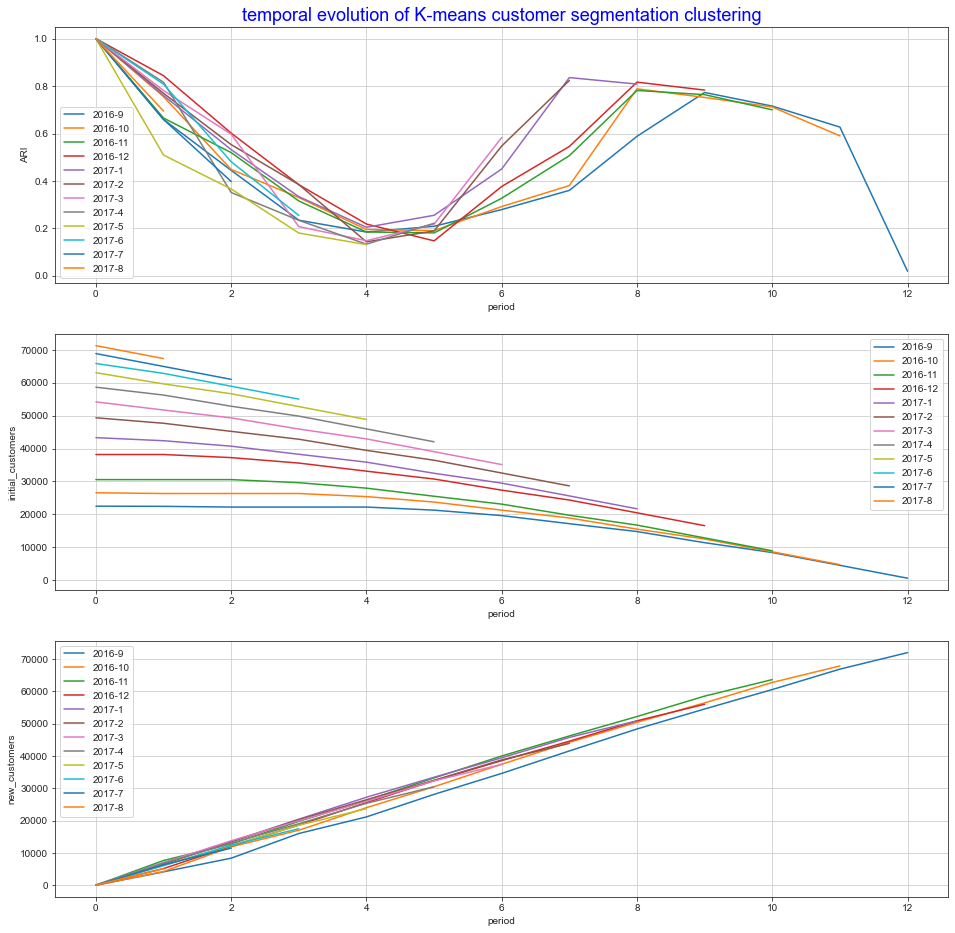

In [14]:
fig, (axes) = plt.subplots(1,3,figsize=(16,16))
sns.set_style("ticks",{'axes.grid' : True})

for i in range(0,period-duration):
    #calculate the day 1
    day1= first_day + relativedelta(months=i)
    #get the ARI scores
    scores = ari_score(day1, last_day, duration)
    
    scores = pd.DataFrame(scores, columns=["period", "ARI","initial_customers","new_customers"])
    
    # plot ARI Score 
    plt.subplot(3,1,1)
    plt.title("temporal evolution of K-means customer segmentation clustering",
              fontsize=18,
              color="b")  
    sns.lineplot(data=scores, x="period", y="ARI",legend='brief', 
                 label=str(day1.year)+'-'+str(day1.month))
    
    plt.subplot(3,1,2)    
    sns.lineplot(data=scores, x="period", y="initial_customers",legend='brief', 
                 label=str(day1.year)+'-'+str(day1.month))
    
    plt.subplot(3,1,3)    
    sns.lineplot(data=scores, x="period", y="new_customers",legend='brief', 
                 label=str(day1.year)+'-'+str(day1.month))


plt.show()

- We can see that, whenever the first period we use as reference, after 2 months, the ARI scores plunged to 0.4-0.6, this means half of inital customers changed clusters whileas the number of initials customers stay relatively stable. These changes are du to a significant number of incoming new customers (~10 000).
- We can also observe a improvement of ARI scores between 7 to 9 months, this is du to the plunge of the inital customers numbers, the remaining customers' clusters stayed quite similair with the inital ones. 

## Conclusion

Considering the significant incoming customers each month and the non-stabiliy of existing customers clustering, it's best to refresh every two to four months the customer segmentation clustering.